In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
# Loading the data
finch_beaks_1975=pd.read_csv("finch_beaks_1975.csv")
finch_beaks_2012=pd.read_csv("finch_beaks_2012.csv")

In [43]:
finch_beaks_1975.head(5)

,band,species,"Beak length, mm","Beak depth, mm"
0,2,fortis,9.4,8.0
1,9,fortis,9.2,8.3
2,12,fortis,9.5,7.5
3,15,fortis,9.5,8.0
4,305,fortis,11.5,9.9


In [44]:
finch_beaks_2012.head(5)

,band,species,blength,bdepth
0,19022,fortis,10.0,8.5
1,19028,fortis,12.5,8.9
2,19032,fortis,9.3,7.5
3,19041,fortis,10.3,9.6
4,19044,fortis,11.0,9.2


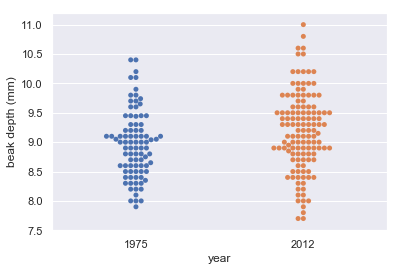

In [45]:
finch_beaks_1975_df = pd.DataFrame(finch_beaks_1975)
finch_beaks_2012_df = pd.DataFrame(finch_beaks_2012)

finch_beaks_1975_gb = finch_beaks_1975_df.groupby(finch_beaks_1975_df['species'])
finch_beaks_1975_scandens = finch_beaks_1975_gb.get_group('scandens').reset_index(drop=True)

finch_beaks_2012_gb = finch_beaks_2012_df.groupby(finch_beaks_2012_df['species'])
finch_beaks_2012_scandens = finch_beaks_2012_gb.get_group('scandens').reset_index(drop=True)

# The depths of scandens beak
scandens_beak_depth_1975=finch_beaks_1975_scandens['Beak depth, mm']
scandens_beak_depth_2012=finch_beaks_2012_scandens['bdepth']

#The lengths of scandens beak
scandens_beak_length_1975=finch_beaks_1975_scandens['Beak length, mm']
scandens_beak_length_2012=finch_beaks_2012_scandens['blength']


s_bd_both = pd.concat([finch_beaks_1975_scandens['Beak depth, mm'],finch_beaks_2012_scandens['bdepth']],axis=1).reset_index(drop=True)
s_bd_both.rename(columns={'Beak depth, mm' : '1975','bdepth' : '2012'},inplace=True)

#EDA of beak depths of Darwin's finches
#visualization of beak depth

#1. Swarmplot
sns.set()
_=sns.swarmplot(data=s_bd_both)
_=plt.xlabel('year')
_=plt.ylabel('beak depth (mm)')

We can't tell if there's a clear difference between the 1975 and 2012 data set but it appears 
as though the mean of the 2012 data set might be slightly higher, and it might have a bigger variance.

## ECDF of the beak depths

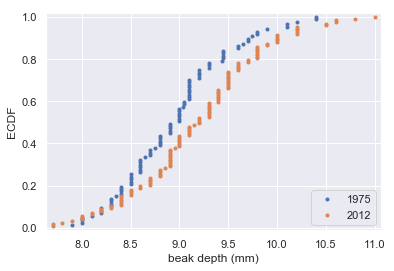

In [46]:
# ecdf calculation functiom
def ecdf(x_data) :
    x = np.sort(x_data)
    y = np.arange(1,len(x)+1) / len(x)

    return x,y

#bootstarp 1D function
def bs_rep_1d(data,func) :
    return func(np.random.choice(data,size=len(data)))

# bottstarp replicate function
def bs_reps(data,func,size=1) :

    bs_rep = np.empty(size)

    for i in range(size) :
        bs_rep[i] = bs_rep_1d(data,func)
    return bs_rep

# linear regression funcion for pair bootstrap

def bs_pair_linreg(x,y,size=1) :
    indices = np.arange(len(x))
       
    slope_reps = np.empty(size)
    intercept_reps = np.empty(size)

    for i in range(size) :
        bs_indices = np.random.choice(indices,size=len(indices))
        bs_x,bs_y = x[bs_indices],y[bs_indices]
        slope_reps[i],intercept_reps[i] = np.polyfit(bs_x,bs_y,1)

    return slope_reps,intercept_reps

# Compute ECDFs
x_1975, y_1975 = ecdf(scandens_beak_depth_1975)
x_2012, y_2012 = ecdf(scandens_beak_depth_2012)

# Plot the ECDFs
_ = plt.plot(x_1975, y_1975, marker='.', linestyle='none')
_ = plt.plot(x_2012, y_2012, marker='.', linestyle='none')

# Set margins
plt.margins(0.02)

# Add axis labels and legend
_ = plt.xlabel('beak depth (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')

# Show the plot
plt.show()

The mean is larger in the 2012 data, and the variance as well

## Parameter estimates of the beak depths

In [47]:
# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(scandens_beak_depth_2012) - np.mean(scandens_beak_depth_1975)

# Get bootstrap replicates of means
bs_rep_1975 = bs_reps(scandens_beak_depth_1975,np.mean,size=10000)
bs_rep_2012 = bs_reps(scandens_beak_depth_2012,np.mean,size=10000)

# Compute samples of difference of means: bs_diff_replicates
bootstrap_rep= bs_rep_2012 - bs_rep_1975

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bootstrap_rep, [2.5, 97.5])

# Print the results
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.2262204724409429 mm
95% confidence interval = [0.06088026 0.39136972] mm


We can see that from the plot of the ECDF and determination of the confidence interval that scandens beak have gotten deeper. But it might be possible that this effect is just due to random chance? What is the probability that we would get the observed difference in mean beak depth if the means were the same?

## Hypothesis test

In [48]:
#shifting the two data sets so that they have the same mean 
combined_mean = np.mean(np.concatenate((scandens_beak_depth_1975,scandens_beak_depth_2012)))

bd_1975_shift = scandens_beak_depth_1975 - np.mean(scandens_beak_depth_1975) + combined_mean
bd_2012_shift = scandens_beak_depth_2012 - np.mean(scandens_beak_depth_2012) + combined_mean

bs_rep_1975_shift = bs_reps(bd_1975_shift,np.mean,size=10000)
bs_rep_2012_shift = bs_reps(bd_2012_shift,np.mean,size=10000)

bs_shifted_mean_diff = bs_rep_2012_shift - bs_rep_1975_shift

#p value
p= np.sum(bs_shifted_mean_diff >= mean_diff) / len(bs_shifted_mean_diff)
print("[+] p-value = ",p)

[+] p-value =  0.0038


There is a statistically significant difference, in the previous code we got 0.2 mm difference between the means. Changing by 0.2 mm in 37 years is substantial by evolutionary standards. To put it in another perspective, the beak depth would double in only 400 years.

## EDA of beak length and depth

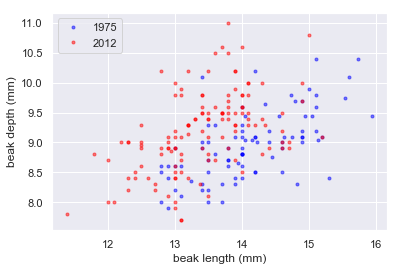

In [49]:
# Make scatter plot of 1975 data
_ = plt.plot(scandens_beak_length_1975, scandens_beak_depth_1975, marker='.',
             linestyle='None', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(scandens_beak_length_2012, scandens_beak_depth_2012, marker='.',
            linestyle='None',color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Show the plot
plt.show()

From the plot, we can see that beaks got deeper (the red points are higher up in the y-direction) and not longer. It's safe to sa that the beaks became shorter and deeper.

## Linear Regression

In [50]:
# Compute the linear regressions
slope_1975,intercept_1975 = np.polyfit(scandens_beak_length_1975,scandens_beak_depth_1975,1)
slope_2012,intercept_2012 = np.polyfit(scandens_beak_length_2012,scandens_beak_depth_2012,1)

# Perform pairs bootstrap for the linear regressions
bs_slope_1975,bs_intercept_1975 = bs_pair_linreg(scandens_beak_length_1975,scandens_beak_depth_1975,size=1000)
bs_slope_2012,bs_intercept_2012 = bs_pair_linreg(scandens_beak_length_2012,scandens_beak_depth_2012,size=1000)

# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_1975,[2.5,97.5])
slope_conf_int_2012 = np.percentile(bs_slope_2012,[2.5,97.5])
intercept_conf_int_1975 = np.percentile(bs_intercept_1975,[2.5,97.5])
intercept_conf_int_2012 = np.percentile(bs_intercept_1975,[2.5,97.5])

# Print the results
print('1975: slope =', slope_1975,
      'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975,
      'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012,
      'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012,
      'conf int =', intercept_conf_int_2012)

1975: slope = 0.4652051691605937 conf int = [0.33071347 0.5912795 ]
1975: intercept = 2.3908752365842267 conf int = [0.6464214  4.29296999]
2012: slope = 0.462630358835313 conf int = [0.33319506 0.60461565]
2012: intercept = 2.9772474982360198 conf int = [0.6464214  4.29296999]


 Seems like they have the same slope, but different intercepts.

## Displaying the linear regression results

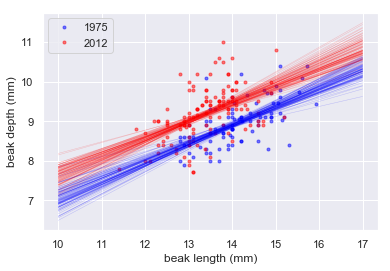

In [51]:
# Make scatter plot of 1975 data
_ = plt.plot(scandens_beak_length_1975, scandens_beak_depth_1975, marker='.',
             linestyle='none', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(scandens_beak_length_2012, scandens_beak_depth_2012, marker='.',
             linestyle='none', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap lines: x
x = np.array([10, 17])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_1975[i] * x + bs_intercept_1975[i],
             linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, bs_slope_2012[i] * x + bs_intercept_2012[i],
             linewidth=0.5, alpha=0.2, color='red')

# Draw the plot again
plt.show()

The linear regression result showed us that the slope was the same in 1975 and 2012 which means for every millimeter gained in beak length, the birds gained about half a millimeter in depth in both years. For the shape of the beak, compare the ratio of beak length to beak depth.

## Beak length to depth ratio

In [52]:
# Compute length-to-depth ratios
ratio_1975 = scandens_beak_length_1975 / scandens_beak_depth_1975
ratio_2012 = scandens_beak_length_2012 / scandens_beak_depth_2012

# Compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means
bs_replicates_1975 = bs_reps(ratio_1975, np.mean, size=10000)
bs_replicates_2012 = bs_reps(ratio_2012, np.mean, size=10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5, 99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5, 99.5])

# Print the results
print('1975: mean ratio =', mean_ratio_1975,
      'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012,
      'conf int =', conf_int_2012)

1975: mean ratio = 1.5788823771858533 conf int = [1.55673935 1.60085764]
2012: mean ratio = 1.4658342276847778 conf int = [1.44447503 1.4879372 ]


The mean beak length-to-depth ratio decreased by about 0.1, or 7%, from 1975 to 2012. The 99% confidence intervals are not even close to overlapping, so this is a real change. The conclusion is: the beak shape changed.